In [1]:
import os
from dotenv import load_dotenv, find_dotenv
from openai import OpenAI
from langchain_openai import ChatOpenAI, OpenAIEmbeddings

load_dotenv(find_dotenv())

api_key = os.environ.get("OPENAI_API_KEY")

llm = ChatOpenAI(model = "gpt-4o",api_key = api_key)
embeddings = OpenAIEmbeddings(model = "text-embedding-ada-002",api_key=api_key)

In [2]:
llm.invoke("Hi")

AIMessage(content='Hello! How can I assist you today?', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 10, 'prompt_tokens': 8, 'total_tokens': 18, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_eb9dce56a8', 'finish_reason': 'stop', 'logprobs': None}, id='run-8d6e7107-9d8f-46cc-bf3c-ddc805b56646-0', usage_metadata={'input_tokens': 8, 'output_tokens': 10, 'total_tokens': 18, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

In [23]:
from typing import Annotated, Dict
from typing_extensions import TypedDict,List,Optional
from pydantic import BaseModel, Field
# from langchain_core.pydantic_v1 import BaseModel, Field
from langgraph.graph import StateGraph,START,END
from langgraph.graph.message import add_messages
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.messages import ToolMessage, AIMessage
import os
import pandas as pd
import numpy as np
import joblib

In [12]:
class LoanParameters(BaseModel):
    Gender: str
    Married: str
    Dependents: str
    Education: str
    Self_Employed: str
    LoanAmount: float
    Loan_Amount_Term: float
    Credit_History: float
    Property_Area: str
    TotalIncome: float

class AgentState(BaseModel):
    user_query: str
    messages: List = Field(default_factory=list)
    task_type: Optional[str] = None
    loan_parameters: Optional[LoanParameters] = None
    eligibility_result: Optional[str] = None
    form_submitted: bool = False

class QueryOutput(BaseModel):
    """Inputs to the Loan Guidance Tool"""
    task_type: str = Field(description = "Type of task to perform based on user_query")

In [13]:
def process_user_query(state: AgentState):
    print("Processing User Query")
    ASSISTANT_PROMPT = """
        You are an expert in managing Loan applications for users and resolving queries of users regarding the same. You are provided with a user_query
        and your task is to go through the query and return the type of task that user wants.
        <Instructions>
            1. Go through the user_query and extract all the relevant key details from the query.
            2. There are three kinds of tasks that can be performed from the query:
                a. 'Loan Eligibility Check' - User would like to check if he/she is eligible for loan.
                b. 'Loan Application Guidance' - User is looking for guidance on how to proceed with his/her Loan Application.
                c. 'Financial Advise' - User is looking for personalized financial advise based on his/her needs.
            3. Only Output the type of task that user wants and no need for any explanation.
        </Instructions>

        <Input>Query:{query}</Input>
    """
    prompt = ChatPromptTemplate.from_template(ASSISTANT_PROMPT)
    user_chain = prompt | llm.with_structured_output(QueryOutput)
    data = user_chain.invoke({"query": state.user_query})
    print(f"Detected task type: {data.task_type}")
    
    # Add an AI message to the conversation
    new_message = AIMessage(content=f"Based on your query, I understand you need: {data.task_type}. Let's proceed with that.")
    state.messages.append(new_message)
    
    # Update state
    state.task_type = data.task_type
    
    # If this is an eligibility check, inform the user about the form
    if state.task_type == "Loan Eligibility Check":
        form_message = AIMessage(content="To check your loan eligibility, please fill out the loan application form with all the required information.")
        state.messages.append(form_message)
    
    return state

In [14]:
def process_form_submission(state: AgentState):
    print("Processing form submission")
    
    # In a real application, we'd get this from a form submission
    # For now, we'll use a sample dict
    sample_form_data = {
        'Gender': 'Male',
        'Married': 'Yes',
        'Dependents': '1',
        'Education': 'Graduate',
        'Self_Employed': 'No',
        'LoanAmount': 250000.0,
        'Loan_Amount_Term': 360.0,
        'Credit_History': 1.0,
        'Property_Area': 'Urban',
        'TotalIncome': 60000.0
    }
    
    # Create LoanParameters object from form data
    state.loan_parameters = LoanParameters(**sample_form_data)
    state.form_submitted = True
    
    # Add a confirmation message
    confirm_message = AIMessage(content="Thank you for submitting your information. I'll now check your loan eligibility.")
    state.messages.append(confirm_message)
    
    return state


In [26]:
def predict_loan_eligibility(state: AgentState):
    print("Predicting loan eligibility")
    
    # Convert parameters to the format needed for prediction
    expected_features = ['Gender', 'Married', 'Dependents', 'Education', 'Self_Employed', 
                         'LoanAmount', 'Loan_Amount_Term', 'Credit_History', 'Property_Area', 'TotalIncome']
    
    # Prepare input for the model
    sample_input = state.loan_parameters.model_dump()
    
    # Convert to DataFrame
    user_df = pd.DataFrame([sample_input])
    print(user_df)
    # Reorder columns to match training data
    user_df = user_df[expected_features]
    
    try:
        # Load category mappings and encode categorical features
        category_mappings = joblib.load('category_mappings.pkl')
        for col, mapping in category_mappings.items():
            if col in user_df.columns:
                user_df[col] = user_df[col].map(mapping).fillna(-1)  # Assign -1 for unseen values
        
        # Load scaler and transform input
        loaded_scaler = joblib.load('scaler.pkl')
        user_scaled = loaded_scaler.transform(user_df)
        
        # Load Model & Predict
        loaded_model = joblib.load('best_loan_model.pkl')
        prediction = loaded_model.predict(user_scaled)
        
        result = 'Eligible' if prediction[0] == 1 else 'Not Eligible'
        
        # Update state with prediction result
        state.eligibility_result = result
        
    except Exception as e:
        # Handle any errors in prediction
        print(f"Error during prediction: {e}")
        state.eligibility_result = "Error during prediction"
    
    # Create response message
    response_message = None
    if state.eligibility_result == 'Eligible':
        response_message = AIMessage(content=f"""
Congratulations! Based on the information you've provided, you are eligible for the loan. 

Here's a summary of your application:
- Loan Amount: ${state.loan_parameters.LoanAmount:,.2f}
- Loan Term: {int(state.loan_parameters.Loan_Amount_Term)} months
- Credit History: {'Good' if state.loan_parameters.Credit_History == 1.0 else 'Limited'}
- Total Income: ${state.loan_parameters.TotalIncome:,.2f}

Would you like guidance on how to proceed with your application?
        """)
    elif state.eligibility_result == 'Not Eligible':
        response_message = AIMessage(content=f"""
Based on the information you've provided, you may not be eligible for the loan under our standard criteria.

Here are some factors that may have affected your eligibility:
- Loan amount too high relative to income
- Credit history concerns
- Loan term duration
- Employment status

Would you like to discuss alternatives or ways to improve your eligibility?
        """)
    else:
        response_message = AIMessage(content=f"I encountered an issue while processing your eligibility. Please try submitting the form again or contact our support team for assistance.")
    
    state.messages.append(response_message)
    
    return state

In [27]:
# Function for loan application guidance
def loan_application_guidance(state: AgentState):
    print("Providing loan application guidance")
    
    guidance_prompt = """
        Provide clear, step-by-step guidance on how to proceed with a loan application. 
        Include information on required documents, typical processes, and best practices.
        
        <UserQuery>{query}</UserQuery>
    """
    
    prompt = ChatPromptTemplate.from_template(guidance_prompt)
    guidance = llm.invoke(prompt.invoke({"query": state.user_query})).content
    
    guidance_message = AIMessage(content=guidance)
    state.messages.append(guidance_message)
    
    return state

# Function for financial advice
def financial_advice(state: AgentState):
    print("Providing financial advice")
    
    advice_prompt = """
        Provide personalized financial advice based on the user's query. 
        Focus on practical, actionable steps they can take.
        
        <UserQuery>{query}</UserQuery>
    """
    
    prompt = ChatPromptTemplate.from_template(advice_prompt)
    advice = llm.invoke(prompt.invoke({"query": state.user_query})).content
    
    advice_message = AIMessage(content=advice)
    state.messages.append(advice_message)
    
    return state


In [28]:
# graph_builder = StateGraph(AgentState)
# #Nodes
# graph_builder.add_node("process_user_query",process_user_query)
# #Edges
# graph_builder.add_edge(START,"process_user_query")
# graph_builder.add_edge("process_user_query",END)
# graph = graph_builder.compile()

def create_loan_agent_graph():
    # Create graph builder
    graph_builder = StateGraph(AgentState)
    
    # Add nodes
    graph_builder.add_node("process_user_query", process_user_query)
    graph_builder.add_node("process_form", process_form_submission)
    graph_builder.add_node("eligibility_check", predict_loan_eligibility)
    graph_builder.add_node("loan_guidance", loan_application_guidance)
    graph_builder.add_node("financial_advice", financial_advice)
    
    # Define conditional routing based on task type
    def route_by_task(state: AgentState):
        if state.task_type == "Loan Eligibility Check":
            return "process_form"
        elif state.task_type == "Loan Application Guidance":
            return "loan_guidance"
        elif state.task_type == "Financial Advise":
            return "financial_advice"
        else:
            # Default fallback
            return "loan_guidance"
    
    # Add edges
    graph_builder.add_edge(START, "process_user_query")
    graph_builder.add_conditional_edges(
        "process_user_query",
        route_by_task,
        {
            "process_form": "process_form",
            "loan_guidance": "loan_guidance",
            "financial_advice": "financial_advice"
        }
    )
    
    # Eligibility check path
    graph_builder.add_edge("process_form", "eligibility_check")
    
    # Final nodes to END
    graph_builder.add_edge("eligibility_check", END)
    graph_builder.add_edge("loan_guidance", END)
    graph_builder.add_edge("financial_advice", END)
    
    # Compile the graph
    return graph_builder.compile()

In [29]:
loan_agent_graph = create_loan_agent_graph()

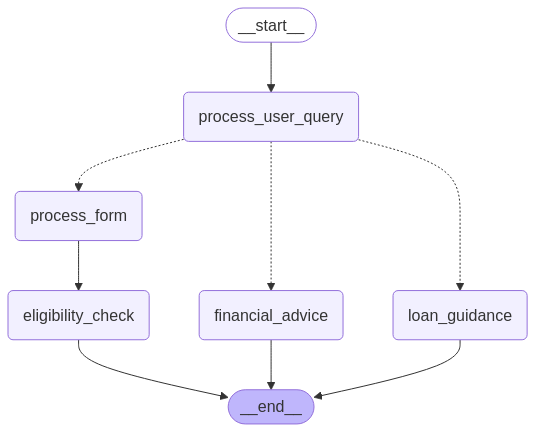

In [30]:
from IPython.display import Image, display

try:
    display(Image(loan_agent_graph.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

In [31]:
config = {"configurable": {"thread_id":1}}
result = loan_agent_graph.invoke({"user_query":"I earn $60,000 annually with a credit score of 710. Would I qualify for a home loan of $250,000?"},config)

Processing User Query
Detected task type: Loan Eligibility Check
Processing form submission
Predicting loan eligibility
  Gender Married Dependents Education Self_Employed  LoanAmount  \
0   Male     Yes          1  Graduate            No    250000.0   

   Loan_Amount_Term  Credit_History Property_Area  TotalIncome  
0             360.0             1.0         Urban      60000.0  


In [32]:
result

{'user_query': 'I earn $60,000 annually with a credit score of 710. Would I qualify for a home loan of $250,000?',
 'task_type': 'Loan Eligibility Check',
 'loan_parameters': LoanParameters(Gender='Male', Married='Yes', Dependents='1', Education='Graduate', Self_Employed='No', LoanAmount=250000.0, Loan_Amount_Term=360.0, Credit_History=1.0, Property_Area='Urban', TotalIncome=60000.0),
 'eligibility_result': 'Not Eligible',
 'form_submitted': True}

In [9]:
result = graph.invoke(
    {
    "user_query":"I've been working as a contractor in the software industry for the past 3 years with an average annual income of $85,000, though it fluctuates month to month. My credit score is around 720, and I have about $18,000 in student loan debt that I'm still paying off. I'm looking to buy a condo in the $350,000 range in Seattle, and I've saved up $40,000 for a down payment. Given my inconsistent income as a contractor and existing debt, would a bank consider me for a mortgage?"
    },
    config
)

Processing User Query
task_type='Loan Eligibility Check'


In [10]:
result = graph.invoke(
    {
    "user_query":"I started an auto loan application online but couldn't finish because I didn't have all the required documents. The system says my application will expire in 3 days. I'm still waiting on proof of insurance for the vehicle I want to purchase, and the dealership hasn't provided the final purchase agreement yet. Is there a way to extend my application time frame? And if I have to restart, will the credit check you already performed still be valid, or will you need to run another one that might further affect my credit score? I'm also wondering if I can change the loan term from 60 months to 48 months at this point without starting over."
    },
    config
)

Processing User Query
task_type='Loan Application Guidance'
